In [145]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 20

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/train.csv


In [146]:
import numpy as np # linear algebra
import pandas as pd # data processing

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [147]:
def check_files_here():
    # поиск файлов в текущей директории
    import os
    for dirname, _, filenames in os.walk('.'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
    return

In [148]:
def download_data(DATA_DIR = '/kaggle/input/sf-dst-scoring/', target = 'default'):
    df_train = pd.read_csv(DATA_DIR+'train.csv')
    df_test = pd.read_csv(DATA_DIR+'test.csv')
    sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

    df_train['sample'] = 1 # помечаем где у нас трейн
    df_test['sample'] = 0 # помечаем где у нас тест
    df_test[target] = 0 # пока просто заполняем нулями
    
    # объединяем df_train и df_test
    df = df_test.append(df_train, sort=False).reset_index(drop=True)
 
    return (df, df_train, df_test, sample_submission)

In [149]:
def null_count(df_in):
    len_df = len(df_in)
    columns_dict = {}
    columns = list(df_in.columns)
    for col in columns:
        col_bin = 0
        n_un = df[col].nunique()
        columns_dict.setdefault(col, [str(type(df_in[col][0])).split("'")[1], n_un, df_in[col].isnull().sum()])
    
    df_columns = pd.DataFrame.from_dict(columns_dict, orient='index', columns = ['type', 'n_unique', 'null_count'])
    df_columns.sort_values(by='null_count', ascending=False, inplace = True)
    df_columns.reset_index(inplace = True)
    df_columns.columns = ['column','type', 'n_unique', 'null_count']
    
    df_columns['null_percent'] = df_columns['null_count'].apply(lambda x: round(x/len_df*100,2))
    
    return df_columns

In [150]:
def log_chart(df_in, col):
    sns.set(font_scale=1.1)
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(14,9))
    sns.distplot(df_in[col], kde = False, rug=False, ax = axes[0])
    sns.distplot(np.log(df_in[col] + 1), kde = False, rug=False, ax = axes[1])
    
    axes[0].set_ylabel('Плотность распределения')
    axes[0].set_xlabel(col)
    
    axes[1].set_ylabel('Плотность распределения (Log(x+1))')
    axes[0].set_xlabel(col)
    
    
    plt.show()
    return

In [151]:
def corr_shart(df_in, col_list):
    sns.set(font_scale=2)
    plt.subplots(figsize=(12, 12))
    sns.heatmap(df_in[col_list].corr(), square=True,
              annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")
    plt.show()
    return

In [152]:
def imp_num_f(df_in, col_list, target = 'default'):
    sns.set(font_scale=1.5)
    imp_num_s = pd.Series(f_classif(df_in[col_list], df_in[target])[0], index = col_list)
    imp_num_s.sort_values(inplace = True)
    imp_num_s.plot(kind = 'barh', figsize=(12, 6))
    plt.show()
    imp_num_s = pd.DataFrame(imp_num_s).reset_index()
    imp_num_s.columns = ['col','imp_ix']
    return imp_num_s

In [153]:
def imp_cat_f(df_in, col_list, target = 'default'):
    sns.set(font_scale=1.5)
    
    imp_cat = pd.Series(mutual_info_classif(df_in[col_list], df_in[target], 
                                            discrete_features =True), index = col_list)
    imp_cat.sort_values(inplace = True)
    imp_cat.plot(kind = 'barh', figsize=(12, 12))
    plt.show()
    imp_cat = pd.DataFrame(imp_cat).reset_index()
    imp_cat.columns = ['col','imp_ix']
    return imp_cat

In [154]:
def labal_encoding(df_in, col_list):
    # Бинарные признаки закодируем как как LabelEncoder
    label_encoder = LabelEncoder()
    for col in col_list:
        df_in[col] = label_encoder.fit_transform(df[col])
    return df_in

In [155]:
def cross_valid(df_in, target = 'default', solver = 'lbfgs', penalty = 'l2', C = 1):
    
    df_in = df_in.sample(len(df_in), random_state = 42)    
    X = df_in[df_in['sample'] == 1].drop(axis = 1, columns = ['sample', target]).values
    Y = df_in[df_in['sample'] == 1][target].values
    
    model = LogisticRegression(max_iter = 500, solver = solver, penalty = penalty, C = C)
    kf = KFold(n_splits=3)

    return cross_val_score(model, X, Y, cv=kf, scoring="roc_auc").mean()

In [156]:
def encod_data(df):
    month_dict = {
    # может инвертировать числа? - нужно
    'JAN': 4,
    'FEB': 3,
    'MAR': 2,
    'APR': 1
    }
    df['day'] = df.app_date.apply(lambda x: int(x[:2]))
    df['month'] = df.app_date.apply(lambda x: month_dict[x[2:5]])
    df['day_month'] = df['month'] + df['day']/30
    #df['year'] = df.app_date.apply(lambda x: int(x[5:])) #год везде 2014
    return df.drop(axis = 1, columns = ['app_date', 'day', 'month'])

In [157]:
def encod_edu(s):
    if s == 'SCH':
        return [1, 0.529]
    elif s == 'UGR':
        return [2, 0.134]
    elif s == 'GRD':
        return [3, 0.317]
    elif s == 'PGR':
        return [4, 0.017]
    elif s == 'ACD':
        return [5, 0.003]

In [158]:
def bin_edu(s):
    if s == 'SCH':
        return 0
    elif s == 'UGR':
        return 0
    elif s == 'GRD':
        return 1
    elif s == 'PGR':
        return 1
    elif s == 'ACD':
        return 1

In [159]:
def vis_importance(df, xcol, ycol):
    # одолжил эту функцию у Sofia Molotkova
    # plot histograms for categorical features to visualize
    # dependence on target variable
    # xcol - feature to explore, ycol - target variable
    
    pd.crosstab(df[xcol], df[ycol]).plot(kind='bar')
    plt.title('Default frequency for {}'.format(xcol))
    plt.xlabel(xcol)
    plt.ylabel('Frequency of default')
    plt.show()

In [160]:
def k_sna(s):
    if s == 1:
        return 0.11
    elif s == 2:
        return 0.18
    elif s == 3:
        return 0.19
    elif s == 4:
        return 0.27

In [161]:
def edu_k(s):
    if s == 'SCH':
        return 0.18
    elif s == 'UGR':
        return 0.15
    elif s == 'GRD':
        return 0.1
    elif s == 'PGR':
        return 0.07
    elif s == 'ACD':
        return 0.04

In [162]:
def w_address(x):
    if x == 1:
        return 0.08
    elif x == 2:
        return 0.11
    elif x == 3:
        return 0.17   

# work_address : 2 k: 0.11
# work_address : 3 k: 0.17
# work_address : 1 k: 0.08

In [163]:
def h_address(x):
    if x == 1:
        return 0.1
    elif x == 2:
        return 0.18
    elif x == 3:
        return 0.13 
# home_address : 1 k: 0.1
# home_address : 2 k: 0.18
# home_address : 3 k: 0.13

# Data Description

Вам предоставлена информация из анкетных данных заемщиков и факт наличия дефолта.

### Описания полей

#### Признаки как в учебной части
- **client_id** - идентификатор клиента

- **education** - уровень образования

- **sex** - пол заемщика

- **age** - возраст заемщика

- **car** - флаг наличия автомобиля

- **car_type** - флаг автомобиля иномарки

- **decline_app_cnt** - количество отказанных прошлых заявок

- **good_work** - флаг наличия “хорошей” работы

- **bki_request_cnt** - количество запросов в БКИ

- **home_address** - категоризатор домашнего адреса

- **work_address** - категоризатор рабочего адреса

- **income** - доход заемщика

- **foreign_passport** - наличие загранпаспорта

#### Новые признаки

- **_sna_** - связь заемщика с клиентами банка

- **_first_time_** - давность наличия информации о заемщике

- **_score_bki_** - скоринговый балл по данным из БКИ

- **_region_rating_** - рейтинг региона

- **_app_date_** - дата подачи заявки

#### Целевая переменная

- **default** - флаг дефолта по кредиту

# Загрузка данных

In [164]:
df, df_train, df_test, sample_submission = download_data()
stat_df = null_count(df)
stat_df

,column,type,n_unique,null_count,null_percent
0,education,str,5,478,0.43
1,client_id,numpy.int64,110148,0,0.00
2,region_rating,numpy.int64,7,0,0.00
3,sample,numpy.int64,2,0,0.00
4,foreign_passport,str,2,0,0.00
5,first_time,numpy.int64,4,0,0.00
6,sna,numpy.int64,4,0,0.00
7,income,numpy.int64,1207,0,0.00
8,work_address,numpy.int64,3,0,0.00
9,home_address,numpy.int64,3,0,0.00


Пропуски только в 'education'. Много бинарных признаков, числовых и категориальных.

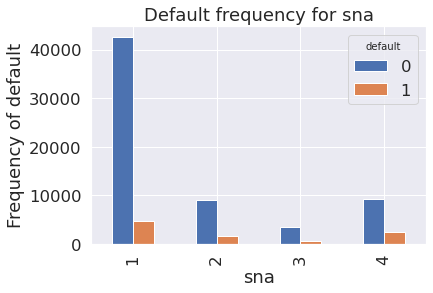

In [165]:
col = 'sna'
vis_importance(df_train, col, 'default')

In [166]:
pool = list(df_train[col].dropna().unique())

for i in pool:
    k = len(df_train[(df_train[col] == i)&(df_train.default == 1)])/len(df_train[(df_train[col] == i)&(df_train.default == 0)])
    print(col,':', i, 'k:', round(k,2))

sna : 4 k: 0.27
sna : 1 k: 0.11
sna : 2 k: 0.18
sna : 3 k: 0.19


<div class="alert alert-block alert-info">
<b>Составим списки признаков по категориям</b>
</div>

In [167]:
cat_cols = ['education', 'home_address', 'work_address','sna', 'first_time','region_rating']
num_cols = ['client_id', 'age', 'decline_app_cnt', 'income', 'bki_request_cnt','score_bki']
bin_cols = list(set(stat_df[stat_df.n_unique == 2].column.values)-{'sample', 'default'})

In [168]:
bin_cols

['foreign_passport', 'car_type', 'good_work', 'sex', 'car']

<div class="alert alert-block alert-info">
<b>Обработаем бинарные признаки через labal_encoding</b>
</div

In [169]:
# найдём и обработаем бинарные признаки через labal_encoding
df = labal_encoding(df, bin_cols)

<div class="alert alert-block alert-warning">
<b>Заполнением пропусков в образовании</b>
</div>

In [170]:
# Замена пропусков модой оказалась самой эффективной на данный момент
mode = df.education.mode()[0]
df.education.fillna(value = mode, inplace = True)

In [171]:
# Идея 1: перекодировать образование в числовой признак: 
# SCH (школа) - 1, 
# UGR (кандидат в бакалавры) - 2, 
# GRD (бакалавр) - 3, 
# PGR (магистр) - 4, 
# ACD (академик) - 5.

# Идея 2: перекодировать образование в бинарный признак: 
# SCH (школа) - 0, 
# UGR (кандидат в бакалавры) - 0, 
# GRD (бакалавр) - 1, 
# PGR (магистр) - 1, 
# ACD (академик) - 1.

<div class="alert alert-block alert-info">
<b>Feature Engineering</b>
</div>

In [172]:
num_to_log = []

In [173]:
# поделим доход на рейтинг региона
df['inc_per_rating'] = df.income/df.region_rating
num_cols.append('inc_per_rating')

# поделим количество запросов в БКИ на давность наличия информации о заёмщитке
df['intensity_brc'] = df['bki_request_cnt']/df['first_time']
num_cols.append('intensity_brc')
# num_to_log.append('intensity_brc')

# декодируем дату обращения в дни и месяцы (год у всех одинаков)
df = encod_data(df)
#cat_cols.append('month')
num_cols.append('day_month')
#cat_cols.remove('app_date')
# num_cols.append('day') дни убрал в связи с малой значимостью признака

# поделим количество запросов в БКИ на давность наличия информации о заёмщитке
df['intensity_brc_2'] = df['bki_request_cnt']/df['day_month']
num_cols.append('intensity_brc_2')
# num_to_log = ['intensity_brc_2']

# поделим количество запросов в БКИ на id
# df['intensity_brc_2'] = df['bki_request_cnt']/df['client_id']
# num_cols.append('intensity_brc_2')

# Флаг клиентов с id менее 5000
df['def_forigin_5000'] = df['client_id'].apply(lambda x: 1 if x < 5000 else 0)
bin_cols.append('def_forigin_5000')

# Флаг клиентов с id более 85000
df['def_forigin_85000'] = df['client_id'].apply(lambda x: 1 if x > 85000 else 0)
bin_cols.append('def_forigin_85000')

# df['id_prod_income'] = (df['client_id']-df['client_id'].min())*df['income']
# num_cols.append('id_prod_income')

# df['rank_edu'] = df['education'].apply(lambda x: encod_edu(x)[0])
# num_cols.append('rank_edu')

# df['bin_edu'] = df['education'].apply(lambda x: bin_edu(x))
# bin_cols.append('bin_edu')

df['edu_k'] = df['education'].apply(lambda x: edu_k(x))
num_cols.append('edu_k')


df = df.drop(axis = 1, columns = ['education'])
cat_cols.remove('education')

df['k_sna'] = df['sna'].apply(lambda x: k_sna(x))
num_cols.append('k_sna')

df = df.drop(axis = 1, columns = ['sna'])
cat_cols.remove('sna')

# df['w_address'] = df['work_address'].apply(lambda x: w_address(x))
# df['h_address'] = df['home_address'].apply(lambda x: h_address(x))
# # df['w_h_address'] = df['w_address'] + df['h_address']
# # df = df.drop(axis = 1, columns = ['w_address','h_address','work_address','home_address'])
# # cat_cols.remove('home_address')
# # cat_cols.remove('work_address')
# #num_cols.append('w_h_address')
# num_cols.append('h_address')
# num_cols.append('w_address')

# категориальные переменные закодируем в демипеременные
df = pd.get_dummies(df, columns=cat_cols, dummy_na=False)
bin_cols = list(set(stat_df[stat_df.n_unique == 2].column.values)-{'sample', 'default'})
cat_cols = list(set(df.columns)-set(num_cols)-set(bin_cols)-{'default', 'sample'})

In [174]:
# sns.kdeplot(df_train.loc[df_train.default == 0, 'client_id'], label = 'default == 0')
# sns.kdeplot(df_train.loc[df_train.default == 1, 'client_id'], label = 'default == 1')

<div class="alert alert-block alert-info">
<b>Логарифмирование числовых переменных (выборочно)</b>
</div>

In [175]:
#log_chart(df, 'id_prod_income') # грифик до и после логарифмирования

In [176]:
for x in ['decline_app_cnt', 'income', 'bki_request_cnt']:
    num_to_log.append(x)
num_to_log

['decline_app_cnt', 'income', 'bki_request_cnt']

In [177]:
for col in num_to_log:
    df[col] = np.log(df[col] + 1)

<div class="alert alert-block alert-info">
<b>Стандартизация всех числовых переменных (всех)</b>
</div>

In [178]:
df[num_cols] = StandardScaler().fit_transform(df[num_cols].values)

<div class="alert alert-block alert-danger">
ДРОПАЕМ ХЛАМ
</div>

In [179]:
#df.drop(axis = 1, columns = ['inc_per_rating'], inplace = True)

<div class="alert alert-block alert-info">
<b>CROSS-VALIDATION</b>
</div>

Лучший результат в версии 9 (то, что дало 3 место на лидер борде) - 0.7350975064400025 на дефолтных гиперпараметрах

- 0.7352012004599332 - после регулирования гиперпараметров (на public данных стало чуть хуже)
- 0.735402074223405 - перекодировал дату иначе (апр - 1, январь - 4) и прибавил day/30 и отправил в числовые признаки
- 0.7354496628128478 - удалил деми переменные с образованием
- 0.7354510527450863 - добавил k_sna. Довольно важный признак оказался (target encoding)
- 0.7354778881382282 - удалил деми переменные sna
- 0.7354778453518412 - добавил k_edu
- 0.7354824397764124 - убрал bin_edu
- 0.7355551378166453 - убрал edu_rank
- 0.7355719453245171 - добавил intensity_brc_2 (без логорифмирования!)
- 0.7355872108002884 - убрал логорифмирование у intensity_brc

In [180]:
cross_valid(df_in = df, target = 'default', solver = 'lbfgs', penalty = 'l2', C = 0.86)

0.7358562195670858

In [181]:
# for i in range(95,110,1):
#     i=i/100
#     print(i, cross_valid(df_in = df, target = 'default', solver = 'liblinear', penalty = 'l1', C = i))

# 0.95 0.7355965237696429
# 0.96 0.7355955123731387
# 0.97 0.7355959171732215
# 0.98 0.7355944166203591
# 0.99 0.7355954219179525
# 1.0 0.7355955465656128
# 1.01 0.7355953457953542
# 1.02 0.7355945179021818
# 1.03 0.7355959271551445
# 1.04 0.7355967006562283
# 1.05 0.7355963750475483
# 1.06 0.7355954126933639
# 1.07 0.7355963104671979
# 1.08 0.7355932754919413
# 1.09 0.7355953669455552

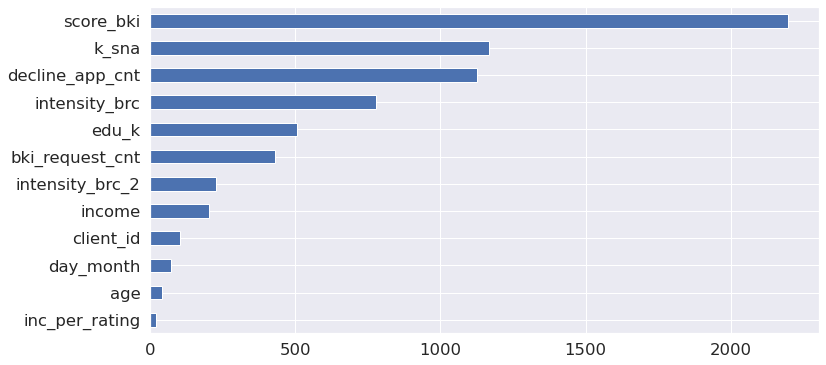

In [182]:
imp_num = imp_num_f(df_in = df, col_list = num_cols, target = 'default')

In [183]:
imp_num[imp_num.imp_ix < imp_num.imp_ix.quantile(0.05)]

,col,imp_ix
0,inc_per_rating,20.573958


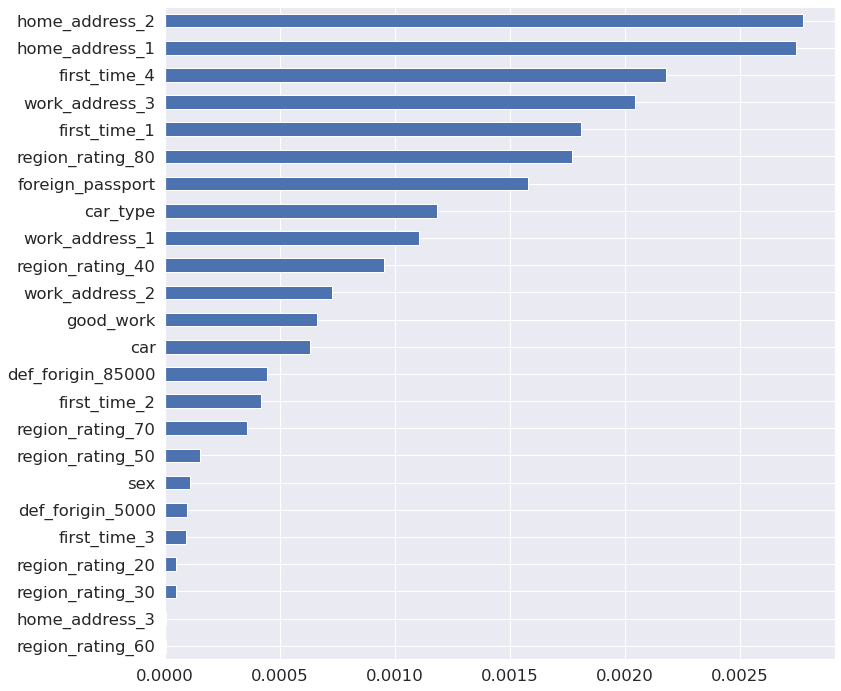

In [184]:
imp_cat = imp_cat_f(df_in = df, col_list = cat_cols + bin_cols, target = 'default')

In [185]:
imp_cat[imp_cat.imp_ix < imp_cat.imp_ix.quantile(0.07)]

,col,imp_ix
0,region_rating_60,0.000003
1,home_address_3,0.000006


## Попробуем удалить малозначимые признаки

In [186]:
# useless_fatures = ['inc_per_rating','region_rating_60', 'home_address_3', 'education_UGR']
# for col in useless_fatures:
#     df_new = df.drop(axis = 1, columns = [col])
#     print(col, cross_valid(df_in = df_new, target = 'default', solver = 'lbfgs', penalty = 'l2', C = 0.86))
    
# inc_per_rating 0.7352893852396828
# region_rating_60 0.7353934317114899
# home_address_3 0.7353940120265293
# education_UGR 0.7353944585218125

In [187]:
# all_fatures = set(df.columns) - set(['sample', 'default', 'client_id'])

In [188]:
# for col in all_fatures:
#     df_new = df.drop(axis = 1, columns = [col])
#     print(round(cross_valid(df_in = df_new, target = 'default', solver = 'lbfgs', penalty = 'l2', C = 0.86)-0.7353927259452525,5), col)
# -0.00033 foreign_passport
# -0.03028 score_bki
# -0.0036 decline_app_cnt
# 0.0 education_PGR
# -0.0 work_address_1
# -0.0001 inc_per_rating
# -0.0 sna_3
# 0.0 region_rating_20
# 0.0 education_UGR
# -0.0 sna_1
# -0.0 education_SCH
# -0.0023 sex
# 0.0 first_time_4
# -0.00094 def_forigin_85000
# -0.0 first_time_2
# 0.0 first_time_1
# -0.0 region_rating_70
# 0.0 region_rating_60
# -0.0 sna_2
# -0.0 car
# 1e-05 rank_edu
# -0.00064 car_type
# 0.0 work_address_2
# 0.0 work_address_3
# 0.0 day_month
# -0.0 region_rating_30
# -0.00022 bki_request_cnt
# 4e-05 intensity_brc
# 0.0 home_address_2
# 0.0 home_address_1
# 0.0 sna_4
# -9e-05 income
# 0.0 education_ACD
# 0.0 home_address_3
# -1e-05 region_rating_80
# -0.00056 good_work
# 0.0 education_GRD
# 0.0 region_rating_40
# -6e-05 age
# -0.0 first_time_3
# 4e-05 def_forigin_5000
# 0.0 bin_edu
# 1e-05 region_rating_50

Попробуем сэмплирование

In [189]:
#len(df[(df.default==0) & (df['sample'] == 1)]) - 64 427

In [190]:
#len(df[(df.default==1) & (df['sample'] == 1)]) 9 372

In [191]:
# for i in range(3):    
#     num_0 = 30000
#     num_1 = 6000

#     df0 = df[(df.default==0) & (df['sample'] == 1)].sample(num_0, replace = False)     
#     df1_1 = df[(df.default==1) & (df['sample'] == 1)].sample(num_1, replace = False)
#     df1_2 = df[(df.default==1) & (df['sample'] == 1)].sample(int(num_1*0.15), replace = True)
#     df_1 = df1_1.append(df1_2)
    
#     df_t = df[(df['sample'] == 0)]

#     df_sample = df0.append(df1)
#     df_sample = df_sample.append(df_t)

#     print(cross_valid(df_in = df_sample, target = 'default', solver = 'lbfgs', penalty = 'l2', C = 0.86))

In [192]:
# def sample_valid_test(df, df_in, target = 'default', s = 'sample',solver = 'lbfgs', penalty = 'l2', C = 1):
    
#     df_in = df_in.sample(len(df_in), random_state = 0)    
#     X = df_in[df_in[s] == 1].drop(axis = 1, columns = [s, target]).values
#     Y = df_in[df_in[s] == 1][target].values
    
#     model = LogisticRegression(max_iter = 500, solver = solver, penalty = penalty, C = C)
#     model.fit(X, Y)
    
#     X_test = df[df[s] == 1].drop(axis = 1, columns = [s, target]).values
#     y_test = df[df[s] == 1][target].values
    
#     y_pred = model.predict_proba(X_test)[:,1]
    
#     result = roc_auc_score(y_test, y_pred)
    
#     return result

In [193]:
# # случайный андерсэмплинг
# for i in range(1,6,1):
#     num_0 = 35000
#     num_1 = 9000
#     df0 = df[(df.default==0) & (df['sample'] == 1)].sample(num_0, replace = True)     
#     df1 = df[(df.default==1) & (df['sample'] == 1)].sample(num_1, replace = True)
#     df_sample = df0.append(df1)
#     print(i, sample_valid_test(df = df, df_in = df_sample, target = 'default', s = 'sample',solver = 'lbfgs', penalty = 'l2', C = 0.86))

<div class="alert alert-block alert-warning">
<b>Неудачный вариант:</b> Обучал 5 моделей и принимал среднее значение как конечный результат предсказания.
</div>

In [194]:
# def fit_models(df, num_0 = 35000, num_1 = 16000):
    
#     def sampling_for_fit(df, num_0, num_1):
        
#         df0 = df[(df.default==0) & (df['sample'] == 1)].sample(num_0, replace = True)     
#         df1 = df[(df.default==1) & (df['sample'] == 1)].sample(num_1, replace = True)
#         df_sample = df0.append(df1)
        
#         df_sample = df_sample.sample(len(df_sample))
        
#         X = df_sample[df_sample['sample'] == 1].drop(axis = 1, columns = ['sample', 'default']).values
#         Y = df_sample[df_sample['sample'] == 1]['default'].values
                
#         return X, Y
        
#     model_1 = LogisticRegression(max_iter = 500, solver = 'lbfgs', penalty = 'l2', C = 0.86)
#     X, Y = sampling_for_fit(df, num_0, num_1)
#     model_1.fit(X, Y)
    
#     model_2 = LogisticRegression(max_iter = 500, solver = 'lbfgs', penalty = 'l2', C = 0.86)
#     X, Y = sampling_for_fit(df, num_0, num_1)
#     model_2.fit(X, Y)   
    
#     model_3 = LogisticRegression(max_iter = 500, solver = 'lbfgs', penalty = 'l2', C = 0.86)
#     X, Y = sampling_for_fit(df, num_0, num_1)
#     model_3.fit(X, Y)
    
#     model_4 = LogisticRegression(max_iter = 500, solver = 'lbfgs', penalty = 'l2', C = 0.86)
#     X, Y = sampling_for_fit(df, num_0, num_1)
#     model_4.fit(X, Y)   
    
#     model_5 = LogisticRegression(max_iter = 500, solver = 'lbfgs', penalty = 'l2', C = 0.86)
#     X, Y = sampling_for_fit(df, num_0, num_1)
#     model_5.fit(X, Y)
    
    
#     X_test = df[df['sample'] == 0].drop(axis = 1, columns = ['sample', 'default']).values
#     #y_test = df[df['sample'] == 1]['default'].values
    
#     y_pred_1 = model_1.predict_proba(X_test)[:,1]
#     y_pred_2 = model_2.predict_proba(X_test)[:,1]
#     y_pred_3 = model_3.predict_proba(X_test)[:,1]
#     y_pred_4 = model_4.predict_proba(X_test)[:,1]
#     y_pred_5 = model_5.predict_proba(X_test)[:,1]
    
#     y_pred = (y_pred_1 + y_pred_2 + y_pred_3 + y_pred_4 + y_pred_5)/5
    
#     #result = roc_auc_score(y_test, y_pred)
    
#     return y_pred

# y_pred = fit_models(df, num_0 = 35000, num_1 = 16000)    

In [195]:
# max_result = 0
# best_num_0 = 0
# best_num_1 = 0
# for num_0 in range(10000,46000,5000):
#     for num_1 in range(4000,19000,2000):
#         result = fit_models(df, num_0 = 35000, num_1 = 16000)
#         if max_result < result:
#             max_result = result
#             best_num_0 = num_0
#             best_num_1 = num_1
#             print('max_result:', max_result, 'best_num_0:', best_num_0, 'best_num_1:', best_num_1)
# print('ИТОГО max_result:', max_result, 'best_num_0:', best_num_0, 'best_num_1:', best_num_1)

<div class="alert alert-block alert-warning">
<b>ПОДБОР ГИПЕРПАРАМЕТРОВ</b>
</div>

In [196]:
#cross_valid(df_in = df_sample, target = 'default', s = 'sample',solver = 'liblinear', penalty = 'l1', C = 1.02)

In [197]:
# for c in range(86,87,1):
#     c=c/100
#     print('C: ',c)
#     print(cross_valid(df_in = df, target = 'default', s = 'sample',solver = 'lbfgs', penalty = 'none', C = c))

In [198]:
# for c in range(100,101,1):
#     c=c/100
#     print('C: ',c)
#     print(cross_valid(df_in = df, target = 'default', s = 'sample',solver = 'sag', penalty = 'none', C = c))

In [199]:
# cross_valid(df_in = df, target = 'default', s = 'sample',solver = 'liblinear', penalty = 'l1', C = 1.02)

<div class="alert alert-block alert-success">
SUBMISSION
</div>

In [200]:
X = df[df['sample'] == 1].drop(axis = 1, columns = ['sample', 'default']).values
Y = df[df['sample'] == 1]['default'].values


model = LogisticRegression(max_iter = 500, solver = 'liblinear', penalty = 'l1', C = 1.04)
model.fit(X, Y)
X_test = df[df['sample'] == 0].drop(axis = 1, columns = ['sample', 'default']).values
y_pred = model.predict_proba(X_test)[:,1]

In [201]:
submission = pd.DataFrame(data = df[df['sample'] == 0]['client_id'].values, columns = ['client_id'])
submission['default'] = y_pred
submission['client_id'] = df_test.client_id
submission.to_csv('submission.csv', index=False)

In [202]:
# Проверка файла
df_sub = pd.read_csv('submission.csv')
df_sub

,client_id,default
0,74835,0.041277
1,17527,0.335421
2,75683,0.064700
3,26883,0.086742
4,28862,0.024919
...,...,...
36344,83775,0.353056
36345,106254,0.017068
36346,81852,0.349123
36347,1971,0.197947
